In [382]:
import nsaba
from nsaba.visualizer import NsabaVisualizer
from nsaba.geneinfo import gene_info
import pandas as pd
from scipy import stats
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Loading NS & ABA datafiles

data_dir = '../data_dir'
nsaba.Nsaba.aba_load(data_dir)
nsaba.Nsaba.ns_load(data_dir)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.


0

In [171]:
# Intializing Nsaba object and loading gene expression

tnsaba = nsaba.Nsaba()
tnsaba.load_ge_pickle('../data_dir/Nsaba_ABA_ge.pkl')

'ge' dictionary successfully loaded


In [465]:
tnsaba.is_term('memory')

True

In [466]:
# Setting term and Entrez IDs

term = 'memory'
gene = [1741] # Implicated in learning: http://www.genecards.org/cgi-bin/carddisp.pl?gene=DLG3

In [467]:
# Generating estimated tf-idf coefficients

tnsaba.get_ns_act(term, thresh=-1)

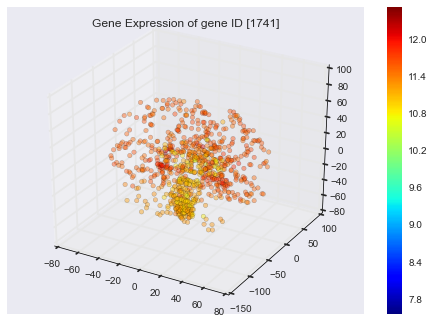

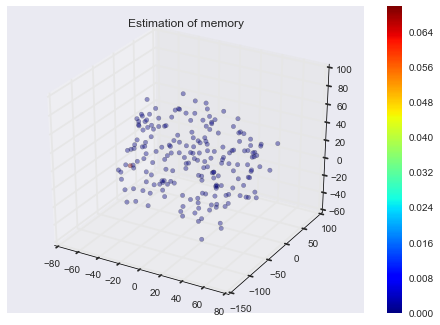

In [468]:
# Visualizing coefficient distribution

V = NsabaVisualizer(tnsaba)
V.visualize_ge(gene)
V.visualize_ns(term)

In [524]:
# Descriptive statistics of term and gene coefficients

analmat = tnsaba.make_ge_ns_mat(term, [65266])
tsaba_df = pd.DataFrame(analmat)
tsaba_df.describe()

,0,1
count,893.000000,893.000000
mean,2.397608,0.024308
std,0.826404,0.023918
min,1.279049,0.000000
25%,1.951361,0.006104
50%,2.293125,0.017323
75%,2.590338,0.034511
max,8.331372,0.157991


In [525]:
# Hypothesis testing pre-processing
thres = .080

gt_thres = [row[0] for row in analmat if row[1] > thres]
lt_thres = [row[0] for row in analmat if row[1] <= thres]
len(gt_thres)

33

In [526]:
# T-Test
print "t-value: %.4f \np-value: %.3E \n" % stats.ttest_ind(lt_thres, gt_thres)
# U-Test
print "Rank: %d \np-value: %.3E " % stats.mannwhitneyu(lt_thres, gt_thres)

t-value: -5.8998 
p-value: 5.165E-09 

Rank: 9521 
p-value: 6.622E-04 


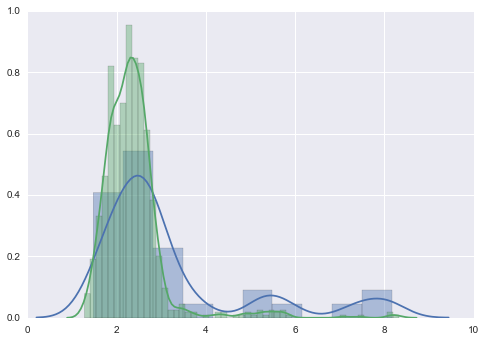

In [527]:
# Distributions of LT & GT thresholds

sns.distplot(gt_thres);
sns.distplot(lt_thres);

In [510]:
# Finding smallest p-values across all Entrez IDs

## Parameters:
term = 'memory'
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
thres = .08
test = 't' # 'u'
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")

aba_sam_num = len(tnsaba.ge[random.choice(tnsaba.ge.keys())])    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] > thres]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] <= thres]
    if test == 'u':
        gene_p.append( (eid, stats.mannwhitneyu(lt_thres, gt_thres)) )
    elif test == 't':
        test_stats = stats.ttest_ind(lt_thres, gt_thres)
        if test_stats[0] <= 0:
            gene_p.append( (eid, test_stats) )
        else:
            continue
    else:
        raise ValueError("test parameter not valid; select 'u' or 't'")

# Sorting from largest to smallest t-statistics
gene_p.sort(key=lambda ge: ge[1][0])

In [518]:
gene_dict = {}
for i in xrange(top_id_return):
    try:
        gene_dict[gene_p[i][0]] = (gene_p[i][1][1], nsaba.geneinfo.gene_info(str(gene_p[i][0]))[0])
    except TypeError:
        continue
## Some ABA genes are not registered with NIH

In [519]:
for k in gene_dict:
    if len(gene_dict[k][1]) == 1:
        print "%d (p = %.3E): < No description found >\n\n" % (k, gene_dict[k][0]/2)    
    else:
        print "%d (p = %.3E): %s\n\n" % (k, gene_dict[k][0]/2, gene_dict[k][1])

84870 (p = 4.124E-07): This gene belongs to the R-spondin family. The encoded protein plays a role in the regulation of Wnt (wingless-type MMTV integration site family)/beta-catenin and Wnt/planar cell polarity (PCP) signaling pathways, which are involved in development, cell growth and disease pathogenesis. Genome-wide association studies suggest a correlation of this gene with bone mineral density and risk of fracture. This gene may be involved in tumor development. [provided by RefSeq, Jul 2013]


5128 (p = 1.736E-07): The protein encoded by this gene belongs to the cdc2/cdkx subfamily of the ser/thr family of protein kinases. It has similarity to a rat protein that is thought to play a role in terminally differentiated neurons. Alternatively spliced transcript variants encoding different isoforms have been found. [provided by RefSeq, Jul 2010]


55061 (p = 6.308E-07): < No description found >


26526 (p = 2.756E-08): The protein encoded by this gene is a member of the transmembrane

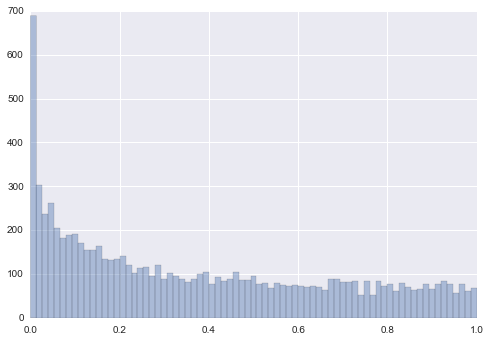

In [520]:
# Visualizing p-value distribution
p_vals = [p[1][1] for p in gene_p ]
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False)

In [521]:
pd.DataFrame(p_vals).describe().astype(double)

,0
count,8.284000e+03
mean,3.698405e-01
std,3.037127e-01
min,5.165372e-09
25%,9.366451e-02
50%,2.993207e-01
75%,6.210142e-01
max,9.998472e-01
